In [1]:
from patchseq_utils import l1_load
from patchseq_utils import util
from importlib import reload
reload(l1_load)
reload(util)

<module 'patchseq_utils.util' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/util.py'>

In [2]:
from patchseq_utils.l1_load import *
from patchseq_utils.util import *

In [3]:
from patchseq_utils import plotting as plot, analysis as utils
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set(style='ticks', context='talk')
pd.options.display.max_columns=300
pd.options.display.max_rows=300

In [5]:
from neuron_morphology.swc_io import morphology_from_swc
from patchseq_utils.lims import get_swc_path

In [6]:
mouse_df = mouse_df.loc[lambda df: df.structure.str.contains('VIS')]
human_l12 = human_df.loc[ lambda df: (df['layer']=='1') |
                         ((df['layer']=='2') & (df['normalized_layer_depth'] < 0.2))]
mouse_l12 = mouse_df.loc[ lambda df: (df['layer']=='1') |
                         ((df['layer']=='2/3') & (df['normalized_layer_depth'] < 0.2))]
combined_l12 = pd.concat([human_l12, mouse_l12], 
                           sort=False).dropna(subset=['homology_type']).copy()

In [7]:
from collections import defaultdict


from neuron_morphology.constants import (
    SOMA, AXON, APICAL_DENDRITE, BASAL_DENDRITE)

def visit(morphology, node, index, step, dist, dendro):
    if node['type'] == SOMA:
        return index, dist
    compartment = morphology.get_compartment_for_node(node)
    dist += morphology.get_compartment_length(compartment)
            
    if dist >= index*step:
        # area = np.pi*(node['radius']**2)
        dendro[index].append(node['radius'])
        index += 1
    return index, dist

def calculate_cross_section_profile(morphology, root=None, index=0, step=5, dist=0, dendro=None, node_types=None):
    if index==2:
        return dendro
    if node_types is None:
        node_types = [SOMA, AXON, APICAL_DENDRITE, BASAL_DENDRITE]
    if root is None:
        root = morphology.get_root()
    if dendro is None:
        dendro = defaultdict(list)
    
    index, dist = visit(morphology, root, index, step, dist, dendro)
    
    while len(morphology.get_children(root)) > 0:
        children = morphology.get_children(root)
        # the next node is a continuation from this node 
        if len(children) == 1:
            root = children[0]
            index, dist = visit(morphology, root, index, step, dist, dendro)
        else:
            # we reached a bifurcation point
            for child in children:
                if child['type'] in node_types:
                    dendro = calculate_cross_section_profile(morphology, child, index, step, dist, dendro, node_types)
            break
            
    return dendro

In [8]:
def get_profiles(cells):
    profiles = {}
    for cell in cells:
        path = get_swc_path(cell)
        morphology = morphology_from_swc(path)
        dend = calculate_cross_section_profile(morphology, node_types=[BASAL_DENDRITE])
        profiles[cell] = list(map(np.sum, dend.values()))
    return profiles

In [9]:
human_profiles = get_profiles(human_l12.query('has_morph').index)

mouse_profiles = get_profiles(mouse_l12.query('has_morph').index)

In [10]:
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [11]:
def get_volume(profiles, step=5):
    return step*np.sum(profiles)

def get_peak(profiles, step=5, start=10):
    i = start//step
    if len(profiles) <= i:
        return 0
    else:
        return np.max(profiles[i:])
    

In [12]:
data = pd.Series(mouse_profiles)
mouse_l12 = mouse_l12.assign(dendrite_volume=data.map(get_volume), dendrite_cross_section_peak=data.map(get_peak))
data = pd.Series(human_profiles)
human_l12 = human_l12.assign(dendrite_volume=data.map(get_volume), dendrite_cross_section_peak=data.map(get_peak))
combined = pd.concat([mouse_l12, human_l12], sort=False)

In [13]:
utils.subgroup_comparisons(combined,['dendrite_cross_section_peak'],  'homology_type', 'species')

,sig_groups,PAX6,MC4R,LAMP5,L1 VIP,auc_PAX6,auc_MC4R,auc_LAMP5,auc_L1 VIP
feature,,,,,,,,,
dendrite_cross_section_peak,"MC4R, LAMP5",0.8,0.006895,0.002094,0.933333,0.631579,0.888889,0.742706,0.53125


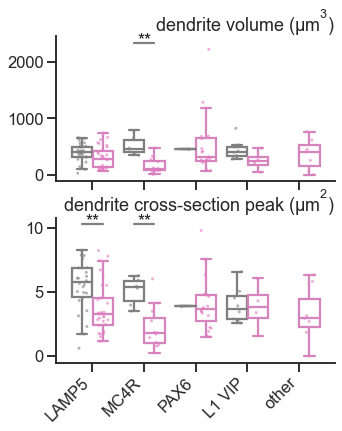

In [19]:
features = ['dendrite_volume', 'dendrite_cross_section_peak']
# utils.plot_boxplot_multiple(data=human_l12, x='homology_type', features=features, palette=palette_subclass)
labels = ['dendrite volume ($µm^3$)', 'dendrite cross-section peak ($µm^2$)']
utils.plot_boxplot_multiple(data=combined, 
                            x='homology_type', features=features, labels=labels,
                            plot_function=plot.plot_nested_comparisons, compare='species', 
                            test_subgroups=True, pad_title=5,
               palette=species_palette, figsize=(5,6))
save_plot_multiple(figdir/"s2_boxplots_morphometrics", ['svg'])

In [39]:
def plot_profiles(profiles, color=species_palette['human'], step=5):
    for profile in profiles:
        plt.plot(step*np.arange(len(profile)), profile, color=color, alpha=0.5)
    mean = pd.DataFrame(profiles).fillna(0).mean(axis=0)
    plt.plot(step*np.arange(len(mean)), mean, 'k')
    plt.ylim(0, 15)
    plt.xlim(0, 300)
    # plt.ylabel('cross-sectional area ($µm^2$)')

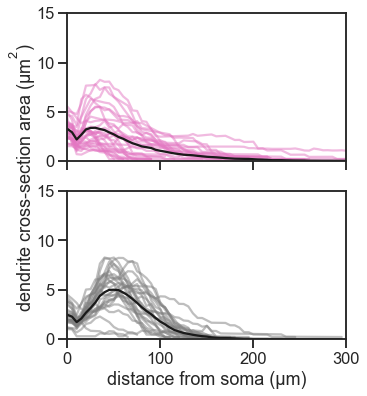

In [43]:
fig, axs = plt.subplots(figsize=(5,6), nrows=2, sharex=True)
plt.sca(axs[0])
plot_profiles([human_profiles[x] for x in human_l12.query("homology_type=='LAMP5'").index 
               if x in human_profiles])

# save_plot_multiple(figdir/"s2_dend_profiles_human", ['svg'])
plt.sca(axs[1])
plot_profiles([mouse_profiles[x] for x in mouse_l12.query("homology_type=='LAMP5'").index 
               if x in mouse_profiles], color=species_palette['mouse'])

fig.text(0.0, 0.5, 'dendrite cross-section area ($µm^2$)', va='center', ha='center',
         rotation='vertical', rotation_mode='anchor')
plt.xlabel('distance from soma (µm)')
save_plot_multiple(figdir/"s2_dend_profiles", ['svg'])

## model results

In [45]:
df_all = pd.read_csv('~/projects/morph_impedance/l1_sims.csv')

In [46]:
import statsmodels.formula.api as smf

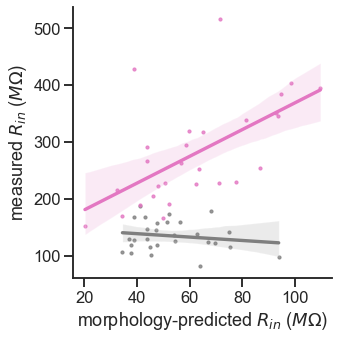

In [5]:
sns.lmplot(data=df_all, y='input_resistance_ss', x='input_resistance_sim', hue='species', 
           scatter_kws=dict(s=10), palette=species_palette, legend=False)
plt.ylabel("measured $R_{in}$ ($M\Omega$)")
plt.xlabel("morphology-predicted $R_{in}$ ($M\Omega$)")
plt.savefig(figdir/"s2_model_comparison_regression.svg", bbox_inches='tight')

In [49]:
utils.posthoc_mw_effects(df_all, 'input_resistance_sim', 'species')

,,pvals,auc
human,mouse,0.098512,0.628079
mouse,human,0.098512,0.628079


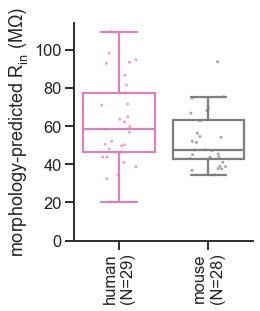

In [53]:
fig, ax = plt.subplots(figsize=(3.2,4))
# sns.boxplot(data=df_all, y='input_resistance_sim', x='species', 
#             palette=palette)
utils.plot_box_cluster_feature(data=df_all, y='input_resistance_sim', x='species', 
            palette=species_palette, ax=ax, label_yaxis=True)
plt.ylabel("morphology-predicted $R_{in}$ ($M\Omega$)")
plt.savefig(figdir/"s2_model_comparison.svg", bbox_inches='tight')

In [56]:
formula = "input_resistance_ss ~ input_resistance_sim"
records=list()
for species in ['mouse','human']:
    res = smf.ols(formula=formula, 
                  data=df_all.query(f"species=='{species}'")
                 ).fit(cov_type='HC3')
    print(res.rsquared, res.pvalues['input_resistance_sim'])
    coeff = res.params['input_resistance_sim']
    err = np.array(res.conf_int_el(param_num=1)) - coeff
    # err = res.conf_int().loc['input_resistance_ss'].values - coeff
    records.append(dict(species=species, err=err, coeff=coeff))
result = pd.DataFrame.from_records(records)


0.02643393545995587 0.46474190180525865
0.35717514504318126 4.393385989311471e-06


<ErrorbarContainer object of 3 artists>

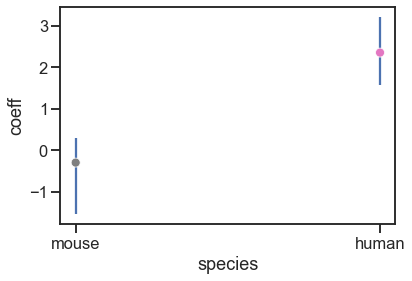

In [33]:

sns.scatterplot(data=res, x='species', y='coeff', hue='species', palette=palette, legend=False)
plt.errorbar(x=[0,1], y=res['coeff'], yerr=res['err'], zorder=-100, fmt='none')

## examples

In [63]:
import patchseq_utils.plot.morphology as pm

In [85]:
human = get_shiny('human')

human_l12 = human_l12.join(human['reconstruction_type'])

In [99]:
cells = human_l12.query("homology_type=='LAMP5' & dendrite_cross_section_peak>7.5")
cells.loc[:,['collaborator','cell_name','reconstruction_type', 'axon_bias_x', 'layer', 't-type', 'structure']]
# for x in cells.swc_path:
#     print(x)

,collaborator,cell_name,reconstruction_type,axon_bias_x,layer,t-type,structure
spec_id,,,,,,,
756894558,Gabor,H18.28.025.11.07.02,100x,16.708815,1,LAMP5 NMBR,SOG
853712464,Gabor,H19.28.009.11.05.02,63x,91.742108,1,LAMP5 NMBR,IOG
1038295890,Gabor,H20.28.022.11.05.02,63x,42.092315,1,LAMP5 LCP2,FroL
1031689414,Gabor,H20.28.011.11.05.05,63x,96.099062,1,LAMP5 LCP2,FroL


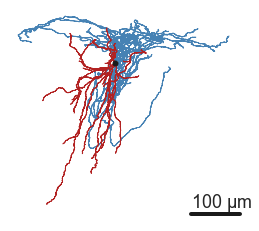

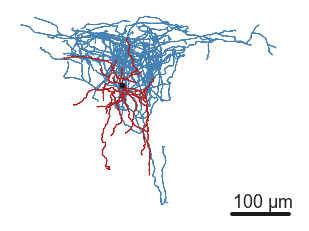

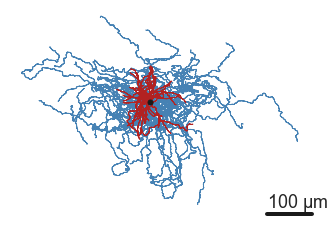

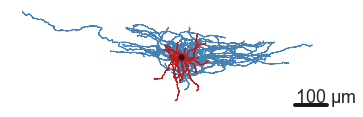

In [66]:
# top two cells are uncannily similar!!
for cell in cells.index:
    pm.plot_cell_lims(cell, rotate=180)

In [ ]:
#plot dendrogram?